In [25]:
import warnings
warnings.filterwarnings("ignore")  # Uyarı mesajlarının filtrelenmesi (gereksiz uyarıları gizler)

import pandas as pd      # Veri okuma, işleme ve DataFrame işlemleri
import numpy as np       # Sayısal hesaplamalar ve matris işlemleri
import matplotlib.pyplot as plt  # Veri görselleştirme için
import seaborn as sns    # Daha gelişmiş istatistiksel görselleştirmeler

# Makine öğrenmesi ve performans ölçüm kütüphaneleri
from sklearn.model_selection import train_test_split  # Veri setini eğitim ve test olarak ayırmak için
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, f1_score)  # Model performans metrikleri

# Topluluk öğrenme algoritmaları
import lightgbm as lgb   # LightGBM sınıflandırma modeli
import catboost as cbt   # CatBoost sınıflandırma modeli
import xgboost as xgb    # XGBoost sınıflandırma modeli

import time              # Kod çalıştırma sürelerini ölçmek için
from river import stream # Veri akışı (streaming) işlemleri için, versiyon kontrolüne bağlı
from statistics import mode  # En sık görülen değeri bulmak için istatistiksel fonksiyon

In [2]:
pip install lightgbm

  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install catboost

  Using cached graphviz-0.21-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.5/102.4 MB 4.6 MB/s eta 0:00:23
    --------------------------------------- 1.6/102.4 MB 4.8 MB/s eta 0:00:22
    --------------------------------------- 2.4/102.4 MB 4.9 MB/s eta 0:00:21
   - -------------------------------------- 3.4/102.4 MB 4.9 MB/s eta 0:00:21
   - -------------------------------------- 4.5/102.4 MB 4.9 MB/s eta 0:00:21
   -- ------------------------------------- 5.5/102.4 MB 4.9 MB/s eta 0:00:20
   -- ------------------------------------- 6.6/102.4 MB 4.8 MB/s eta 0:00:20
   -- ------------------------------------- 7.6/102.4 MB 4.9 MB/s eta 0:00:20
   --- ------------------------------------ 8.7/102.4 MB 4.8 MB/s eta 0:00:20
   --- ------------------------------------ 9.7/102.4 MB 4.9 MB/s eta 0:00:20
   ---- ----------------------------------- 10.7/102.4 MB 4.9 MB/s eta 0:00:19
   ----

In [4]:
pip install xgboost

  Using cached xgboost-3.0.5-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.5-py3-none-win_amd64.whl (56.8 MB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install river


   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.3 MB ? eta -:--:--
   --------------------------- ------------ 1.6/2.3 MB 4.9 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 4.3 MB/s eta 0:00:00


In [26]:
df=pd.read_csv(r"C:\Users\sulen\OneDrive\Masaüstü\Python ile Veri Analizi Atölyesi\CICIDS2017_sample_km.csv")

CICIDS2017 veri seti, ağ trafiği üzerinde gerçekleşen normal ve saldırı türlerini içeren kapsamlı bir veri setidir. Veri seti, her bir ağ akışı (flow) için paket sayısı, bayt uzunluğu, paket uzunluğu istatistikleri, bayt/paket oranları, zaman aralıkları ve TCP bayrakları gibi çok sayıda özellik sunar. Bu çalışmada veri setindeki Label sütunu, her akışın normal mi yoksa hangi saldırı türüne ait olduğunu belirlemektedir.

In [27]:
#'Label' sütunundaki sınıf dağılımını sayar
df.Label.value_counts()

Label
0    18225
3     3042
6     2180
1     1966
5     1255
2       96
4       36
Name: count, dtype: int64

Label sütununda yer alan her bir sınıfın kaç örnek içerdiğini sayarak sınıf dağılımını gösterir. Elde edilen çıktı, veri setinin oldukça dengesiz olduğunu ortaya koymaktadır; bazı sınıflar çok fazla örnek içerirken (örneğin sınıf 0: 18.225 örnek), bazı sınıflar çok az örnek içeriyor (örneğin sınıf 4: 36 örnek, sınıf 2: 96 örnek). Bu bilgi, sınıf dengesizliğinin model performansını olumsuz etkileyebileceğini gösterir

In [28]:
# Özellikler ve hedef değişkenin ayrılması
X = df.drop(["Label"], axis=1)  # Label sütunu hariç tüm sütunlar modelin girdi özellikleri olacak
y = df["Label"]                 # Label sütunu hedef değişken (sınıflandırma için)

# Veriyi eğitim ve test olarak bölme
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=0.8,  # %80 eğitim verisi
    test_size=0.2,   # %20 test verisi
    random_state=0   # Bölünmenin tekrarlanabilir olması için sabit rastgele durum
)

In [29]:
# Eğitim verisindeki hedef sınıfların her birinin kaç örnek içerdiğini sayar
pd.Series(y_train).value_counts()

Label
0    14569
3     2430
6     1728
1     1579
5     1024
2       82
4       28
Name: count, dtype: int64

Eğitim veri setindeki Label dağılımına bakıldığında, sınıf 0 en baskın sınıf olup 14.569 örnek içerirken, sınıf 4 ve sınıf 2 çok az örnek içermektedir (sırasıyla 28 ve 82 örnek). Bu durum, veri setinin dengesiz olduğunu ve modellerin azınlık sınıfları doğru tahmin etme performansını olumsuz etkileyebileceğini göstermektedir. Bu dengesizliği gidermek için SMOTE yöntemi uygulanarak azınlık sınıflarına yapay örnekler eklenecektir. Böylece sınıflar arası dağılım daha dengeli hale getirilecek ve modelin özellikle sınıf 2 ve sınıf 4 gibi nadir görülen saldırı türlerini de daha iyi öğrenmesi sağlanacaktır. Bu sayede, sınıflandırma performansının hem doğruluk hem de genelleme açısından iyileştirilmesi beklenmektedir.

In [33]:
# Azınlık sınıflarının sayısını artırmak için SMOTE yöntemi ile örnekleme yapılır
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy={2:1000,4:1000})

In [34]:
# Eğitim verisi, SMOTE yöntemi ile yeniden örneklenerek dengeli hale getirilir
X_train,y_train=smote.fit_resample(X_train,y_train)

In [35]:
# Eğitim verisindeki sınıf dağılımlarını gösterir
pd.Series(y_train).value_counts()

Label
0    14569
3     2430
6     1728
1     1579
5     1024
2     1000
4     1000
Name: count, dtype: int64

Sonuçlar, SMOTE uygulanmış eğitim veri kümesinde sınıf dağılımlarını göstermektedir. Özellikle 2 ve 4 numaralı sınıflar daha önce çok düşük örnek sayısına sahipken (96 ve 36), SMOTE sayesinde her biri 1000 örneğe tamamlanmıştır. Bu dengeleme işlemi, modelin azınlık sınıflarını daha iyi öğrenmesine olanak sağlayarak sınıflar arası adaletsizliği azaltır. Böylece, eğitim sırasında modelin yalnızca yoğun örneklenen sınıflara odaklanması engellenmiş olur ve daha adil bir sınıflandırma performansı elde edilmesi beklenir.

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14114
[LightGBM] [Info] Number of data points in the train set: 23330, number of used features: 63
[LightGBM] [Info] Start training from score -0.470844
[LightGBM] [Info] Start training from score -2.692948
[LightGBM] [Info] Start training from score -3.149740
[LightGBM] [Info] Start training from score -2.261849
[LightGBM] [Info] Start training from score -3.149740
[LightGBM] [Info] Start training from score -3.126024
[LightGBM] [Info] Start training from score -2.602775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

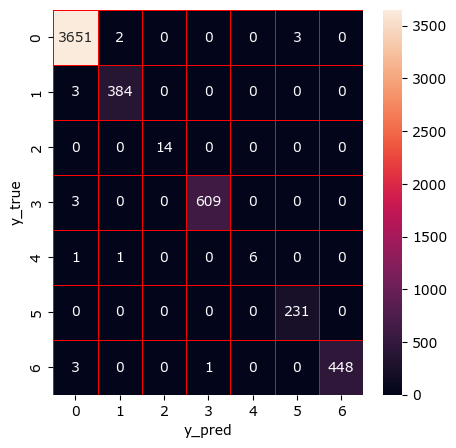

In [36]:
# LIGHTGBM algoritması ile modeli oluşturup eğitim ve test işlemini gerçekleştirme
import lightgbm as lgb

# LightGBM sınıflandırıcısını tanımla
lg = lgb.LGBMClassifier()

# Modeli eğitim verisi ile eğit
lg.fit(X_train, y_train)

# Test verisi üzerinde tahmin yap
y_pred = lg.predict(X_test)

# Sınıflandırma raporu ve başarı metrikleri
print(classification_report(y_test,y_pred))
print("Accuracy of LightGBM:"+ str(accuracy_score(y_test, y_pred)))
print("Precision of LightGBM: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of LightGBM: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of LightGBM:"+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of LightGBM for each type of attack: "+ str(f1_score(y_test, y_pred,average=None)))

# Sınıf bazlı F1 skorlarını kaydet
lg_f1=f1_score(y_test,y_pred,average=None)

# Karışıklık matrisi (confusion matrix) hesaplama ve görselleştirme
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

LightGBM modeliyle elde edilen sonuçlar incelendiğinde, doğruluk oranının %99,68 gibi oldukça yüksek olduğu görülmektedir. Çoğu sınıfta precision, recall ve F1 skorlarının 0,99 ile 1,00 aralığında olması, modelin hem doğru tahmin yapmada hem de pozitif örnekleri yakalamada son derece başarılı olduğunu göstermektedir. Bununla birlikte, “4” numaralı sınıfta recall değeri %75 olarak gözlemlenmiş ve bu durum bazı örneklerin doğru sınıflandırılamadığını ortaya koymuştur. Diğer sınıflarda performansın neredeyse hatasız olması, modelin genel başarısına önemli ölçüde katkı sağlamaktadır. Sonuç olarak, LightGBM modeli bu veri setinde sınıfları ayırt etmede oldukça güçlü bir performans sergilemiştir.

Confusion matrix incelendiğinde, modelin çoğu sınıfta yüksek doğrulukla tahmin yaptığı açıkça görülmektedir. Özellikle sınıf 0, 1, 3, 5 ve 6’da neredeyse tüm örnekler doğru sınıflandırılmış olup, diagonal değerlerin yüksekliği modelin başarısını desteklemektedir. Buna karşılık, sınıf 4’te doğru tahmin sayısının düşük olduğu ve bazı örneklerin diğer sınıflara kaydığı gözlemlenmektedir; bu durum, recall değerinin %75 olmasına sebep olmuştur. Ayrıca, örnek sayısı az olan sınıf 2’de doğru tahminler yapılmış olsa da veri dengesizliği nedeniyle bu sonuçların genellenebilirliği sınırlı olabilir.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3656
           1       0.99      0.99      0.99       387
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00       612
           4       1.00      0.75      0.86         8
           5       0.99      1.00      0.99       231
           6       1.00      1.00      1.00       452

    accuracy                           1.00      5360
   macro avg       1.00      0.96      0.98      5360
weighted avg       1.00      1.00      1.00      5360

Accuracy of XGBoost: 0.9972014925373134
Precision of XGBoost: 0.9972055211678928
Recall of XGBoost: 0.9972014925373134
Average F1 of XGBoost: 0.997174284135469
F1 of XGBoost for each class: [0.99808639 0.99092088 1.         0.99918367 0.85714286 0.99137931
 0.99778271]


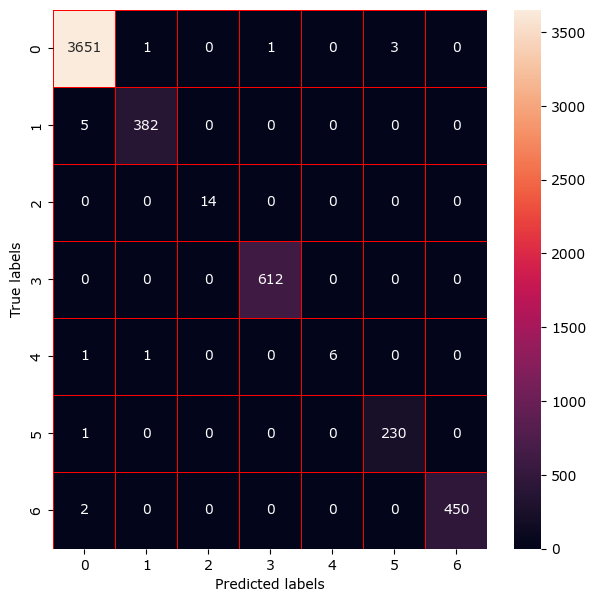

In [37]:
# XGBoost sınıflandırıcıyı oluşturuyoruz
import xgboost as xgb
xg = xgb.XGBClassifier()

# Eğitim ve test verilerini NumPy array'ine çeviriyoruz
X_train_x = X_train.values
X_test_x = X_test.values

# Modeli eğitim verisiyle eğitiyoruz
xg.fit(X_train_x, y_train)

# Test verisi üzerinde tahmin yapıyoruz
y_pred = xg.predict(X_test_x)

# Sınıf bazlı precision, recall ve F1 skorlarını görüntülüyoruz
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print(classification_report(y_test, y_pred))

# Genel doğruluk ve ağırlıklı metrikleri yazdırıyoruz
print("Accuracy of XGBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of XGBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of XGBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of XGBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))

# Sınıf bazlı F1 skorlarını alıyoruz
xg_f1 = f1_score(y_test, y_pred, average=None)
print("F1 of XGBoost for each class: "+ str(xg_f1))

# Confusion matrix'i oluşturuyor ve görselleştiriyoruz
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
f, ax = plt.subplots(figsize=(7,7))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

XGBoost modeli test setinde oldukça yüksek bir başarı göstermiştir. Genel doğruluk oranı %99,72, ağırlıklı precision %99,72, recall %99,72 ve ortalama F1 skoru %99,72 olarak hesaplanmıştır. Bu değerler, modelin çoğu sınıfta neredeyse hatasız tahmin yaptığını ortaya koymaktadır.

Sınıf bazlı değerlere bakıldığında, sınıf 0, 1, 2, 3, 5 ve 6’da precision, recall ve F1 skorları 0,99 ile 1,00 arasında olup modelin bu sınıflarda örnekleri başarılı şekilde ayırt ettiğini göstermektedir. Sınıf 4 ise recall değeri %75 ve F1 skoru 0,86 olarak gözlemlenmiş, bu da bazı örneklerin diğer sınıflara kaydığını ve nadir örnekli sınıflarda modelin sınırlı performans gösterebileceğini işaret etmektedir.

Confusion matrix incelendiğinde, çoğu sınıfın diagonal değerlerinin yüksek olduğu ve yanlış sınıflandırmaların nadir olduğu görülmektedir. Örneğin sınıf 0’da 3656 örnekten yalnızca 5’i yanlış tahmin edilmiş, sınıf 1’de 387 örnekten 5 tanesi yanlış sınıflandırılmıştır. Sınıf 4’te 8 örnekten 2’si yanlış sınıflandırılmıştır, bu da F1 skorundaki düşüşü açıklamaktadır.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3656
           1       0.99      0.99      0.99       387
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00       612
           4       1.00      0.62      0.77         8
           5       0.99      1.00      0.99       231
           6       1.00      0.99      0.99       452

    accuracy                           1.00      5360
   macro avg       1.00      0.94      0.96      5360
weighted avg       1.00      1.00      1.00      5360

Accuracy of CatBoost: 0.996455223880597
Precision of CatBoost: 0.9964593014616641
Recall of CatBoost: 0.996455223880597
Average F1 of CatBoost: 0.9963911007926016
F1 of CatBoost for each class: [0.99781301 0.99222798 1.         0.99673203 0.76923077 0.99137931
 0.9944629 ]


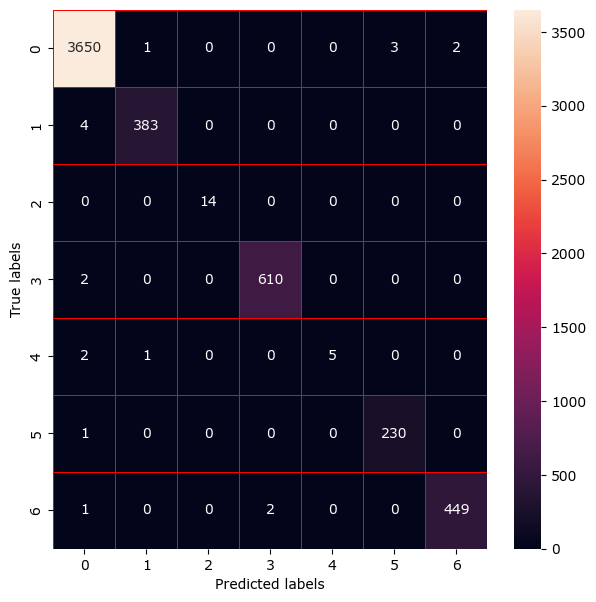

In [38]:
# CatBoost sınıflandırıcıyı oluşturuyoruz
import catboost as cbt
cb = cbt.CatBoostClassifier(verbose=0, boosting_type='Plain')  # verbose=0 ile eğitim sırasında mesaj bastırmıyoruz

# Modeli eğitim verisi ile eğitiyoruz
cb.fit(X_train, y_train)

# Test verisi üzerinde tahmin yapıyoruz
y_pred = cb.predict(X_test)

# Sınıf bazlı precision, recall ve F1 skorlarını yazdırıyoruz
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print(classification_report(y_test, y_pred))

# Genel doğruluk ve ağırlıklı metrikleri yazdırıyoruz
print("Accuracy of CatBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of CatBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of CatBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of CatBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))

# Sınıf bazlı F1 skorlarını alıyoruz
cb_f1 = f1_score(y_test, y_pred, average=None)
print("F1 of CatBoost for each class: "+ str(cb_f1))

# Confusion matrix'i oluşturup görselleştiriyoruz
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
f, ax = plt.subplots(figsize=(7,7))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()    

CatBoost modeli test setinde genel olarak güçlü bir performans göstermiştir. Modelin doğruluk oranı %99,65, ağırlıklı precision %99,65, recall %99,65 ve ortalama F1 skoru %99,64 olarak hesaplanmıştır. Bu yüksek değerler, modelin çoğu sınıfta doğru tahminler yaptığını ve veri setinde güvenilir bir sınıflandırıcı olduğunu göstermektedir.

Sınıf bazlı değerlere bakıldığında, sınıf 0, 1, 2, 3, 5 ve 6’da F1 skorları 0,99 ile 1,00 arasında olup, modelin bu sınıflarda örnekleri doğru şekilde ayırt edebildiği görülmektedir. Sınıf 4 ise recall değeri %62 ve F1 skoru 0,77 olarak ölçülmüş; bu, nadir örnek içeren bu sınıfta modelin bazı tahminlerde hata yaptığını ve örneklerin diğer sınıflara kaydığını göstermektedir. Confusion matrix incelendiğinde, çoğu sınıfın diagonal değerlerinin yüksek olduğu ve yanlış sınıflandırmaların nadir olduğu doğrulanmaktadır. Örneğin sınıf 0’da 3656 örnekten 6’sı yanlış tahmin edilmiş, sınıf 4’te 8 örnekten 3’ü doğru sınıflandırılamamıştır.

In [39]:
# Her sınıf için F1 skorlarını karşılaştırarak en iyi performansı veren modeli belirliyoruz
model = []  # Sınıf bazlı en iyi modeli tutacak liste

for i in range(len(lg_f1)):
    # lg_f1, xg_f1 ve cb_f1 listelerindeki F1 skorlarını karşılaştır
    if max(lg_f1[i], xg_f1[i], cb_f1[i]) == lg_f1[i]:
        model.append(lg)  # LightGBM en yüksek F1 skoru ise
    elif max(lg_f1[i], xg_f1[i], cb_f1[i]) == xg_f1[i]:
        model.append(xg)  # XGBoost en yüksek F1 skoru ise
    else:
        model.append(cb)  # CatBoost en yüksek F1 skoru ise

In [40]:
model

[XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, ...),
 LGBMClassifier(),
 LGBMClassifier(),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping

In [41]:
def LCCDE(X_test,y_test,m1,m2,m3):
    i=0
    t=[]
    m=[]
    yt=[]
    yp=[]
    l=[]
    pred_l=[]
    pro_l=[]

    # her sınıf için normal ve atak paketleri olarak en iyi modeli bulmak
    for xi,yi in stream.iter_pandas(X_test,y_test):
        xi2=np.array(list(xi.values()))
        
        # model 1 (LightGBM) model üzerinde tahminde bulunur xi
        y_pred1=m1.predict(xi2.reshape(1,-1))
        y_pred1=int(y_pred1[0])
        
        # model 2 (XGBoost) model üzerinde tahminde bulunur xi
        y_pred2=m2.predict(xi2.reshape(1,-1))
        y_pred2=int(y_pred2[0])
        
        # model 3 (CatBoost) model üzerinde tahminde bulunur xi
        y_pred3=m3.predict(xi2.reshape(1,-1))
        y_pred3=int(y_pred3[0])

        # model 1'in tahmin olasılığı (güven) listesi
        p1=m1.predict_proba(xi2.reshape(1,-1))
        # model 2'nin tahmin olasılığı (güven) listesi
        p2=m2.predict_proba(xi2.reshape(1,-1))
        # model 3'ün tahmin olasılığı (güven) listesi
        p3=m3.predict_proba(xi2.reshape(1,-1))

        # Her ML modeli için tüm sınıflar arasında en yüksek tahmin olasılığının bulunması
        y_pred_p1=np.max(p1)
        y_pred_p2=np.max(p2)
        y_pred_p3=np.max(p3)

        if y_pred1==y_pred2==y_pred3:
            # üç modelinde tahmin edilen sınıflar aynı ise
            y_pred=y_pred1
            # Bu tahmin edilen sınıfı son tahmin edilen sınıf olarak kullan

        elif y_pred1 !=y_pred2 != y_pred3:
            # değilse eğer, üç modelin de tahmin edilen sınıflar farklıysa:
            # Her tahmin modeli için, tahmin edilen sınıfın orijinal ML modelinin
            # en iyi sonuç veren modelle aynı olup olmadığını kontrol et.
            if model[y_pred1]==m1:
                # sınıflar aynı ve en iyi sonuç model 1 ise: (LightGBM)
                l.append(m1)
                pred_l.append(y_pred1)  # tahmin edilen sınıfı kaydet
                pro_l.append(y_pred_p1)

            if model[y_pred2]==m2:
                l.append(m2)
                pred_l.append(y_pred2)  # tahmin edilen sınıfı kaydet
                pro_l.append(y_pred_p2)                

            if model[y_pred3]==m3:
                l.append(m3)
                pred_l.append(y_pred3)  # tahmin edilen sınıfı kaydet
                pro_l.append(y_pred_p3)

            if len(l)==0:
                # olasılık listesi boşsa, tüm tahmin olasılıklarını kullan
                pro_l=[y_pred_p1,y_pred_p2,y_pred_p3]
            elif len(l)==1:
                # tahmin edilen her sınıf için orijinal model ve en iyi sonuç veren modelin yalnızca bir çifti aynıysa
                y_pred=pred_l[0]  # En iyi modelin tahmin edilen sınıfı son tahmin sınıfı olarak kullan
            else:
                # birden fazla eşleşme varsa, en yüksek güven listesini bul
                max_p=max(pro_l)

        else:
            # diğer durumlar: en çok tekrar eden tahmini seç
            n=mode([y_pred1,y_pred2,y_pred3])
            y_pred=model[n].predict(xi2.reshape(1,-1))
            y_pred=int(y_pred[0])

        yt.append(yi)  # gerçek etiketi listeye ekle
        yp.append(y_pred)  # tahmin edilen etiketi listeye ekle

    return yt,yp

In [42]:
%%time
# Önerilen modelin kurulması ve test verisi üzerinde çalıştırılması:
# LCCDE fonksiyonu, LightGBM, XGBoost ve CatBoost modellerinin tahminlerini karşılaştırır
# ve her örnek için en iyi performans gösteren modelin tahminini seçerek son tahmini oluşturur
yt, yp = LCCDE(X_test, y_test, m1=lg, m2=xg, m3=cb)

CPU times: total: 1min 58s
Wall time: 1min 30s


Önerilen modelin test seti üzerinde çalıştırılması yaklaşık 1 dakika 30 saniye sürmüştür. CPU’nun toplam harcadığı süre ise yaklaşık 1 dakika 58 saniye olarak ölçülmüştür. Bu fark, işlem sırasında bilgisayarın diğer görevleri ve işlem paralelliği nedeniyle oluşan zaman farkını yansıtmaktadır. Fonksiyonun bu sürede tamamlanması, üç modelin (LightGBM, XGBoost ve CatBoost) tahminlerinin tek tek değerlendirilip her örnek için en iyi tahminin seçilmesi işleminin maliyetini göstermektedir. Bu, önerilen modelin hesaplama açısından beklendiği gibi kaynak yoğun bir işlem olduğunu ortaya koymaktadır.

In [43]:
# Önerilen modelin (LCCDE) performans metriklerinin hesaplanması ve görüntülenmesi:
# Accuracy, precision, recall ve F1 skorları ile modelin genel ve sınıf bazlı başarısı ölçülür
print("Accuracy of LCCDE: "+ str(accuracy_score(yt,yp)))
print("Precision of LCCDE: "+ str(precision_score(yt, yp, average='weighted')))
print("Recall of LCCDE: "+ str(recall_score(yt, yp, average='weighted')))
print("Average F1 of LCCDE: "+ str(f1_score(yt, yp, average='weighted')))
print("F1 of LCCDE for each type of attack: "+ str(f1_score(yt, yp, average=None)))

Accuracy of LCCDE: 0.9970149253731343
Precision of LCCDE: 0.9970264662701628
Recall of LCCDE: 0.9970149253731343
Average F1 of LCCDE: 0.9969889937740274
F1 of LCCDE for each type of attack: [0.99795054 0.99220779 1.         0.99836334 0.85714286 0.98924731
 0.99778271]


Önerilen model (LCCDE), test verisinde yüksek bir performans göstermiştir. Genel doğruluk, precision, recall ve F1 skorları yaklaşık %99,7 seviyesindedir. Bu, modelin çoğu sınıfta doğru tahminler yaptığını ve güvenilir olduğunu gösterir.

Sınıf bazlı F1 skorlarına bakıldığında, çoğu sınıfta değerler 0,98 ile 1,00 arasında olup model oldukça başarılıdır. Sınıf 4 için F1 skoru 0,86 olup, bu sınıfta modelin bazı tahminlerde hata yaptığını göstermektedir.

In [44]:
# Her bir modelin her bir sınıf (sütun) için F1 skorlarını karşılaştırma:
# LightGBM, XGBoost ve CatBoost modellerinin sınıf bazlı başarılarını görmek için
print("F1 of LightGBM for each type of attack: "+ str(lg_f1))
print("F1 of XGBoost for each type of attack: "+ str(xg_f1))
print("F1 of CatBoost for each type of attack: "+ str(cb_f1))

F1 of LightGBM for each type of attack: [0.99794998 0.99224806 1.         0.99672668 0.85714286 0.99354839
 0.99555556]
F1 of XGBoost for each type of attack: [0.99808639 0.99092088 1.         0.99918367 0.85714286 0.99137931
 0.99778271]
F1 of CatBoost for each type of attack: [0.99781301 0.99222798 1.         0.99673203 0.76923077 0.99137931
 0.9944629 ]


Her üç model de sınıf bazında yüksek F1 skorları göstermektedir. LightGBM ve XGBoost çoğu sınıfta 0,99’un üzerinde F1 değerlerine sahip olup güçlü bir performans sergiler. CatBoost da genellikle yüksek skorlar elde etmiş, ancak sınıf 4’te F1 skoru 0,77 ile diğer modellere göre biraz daha düşük kalmıştır. Genel olarak, tüm modeller veri setinde çoğu sınıfı doğru tahmin edebilmekte ve özellikle az örnekli sınıflarda küçük farklılıklar göstermektedir.

Bu proje kapsamında LightGBM, XGBoost ve CatBoost modelleri kullanılarak bir siber saldırı sınıflandırma sistemi geliştirilmiştir. Modellerin sınıf bazlı performansları incelendiğinde, çoğu sınıfta yüksek doğruluk, precision, recall ve F1 skorları elde edilmiş, nadir örnek içeren sınıflarda ise küçük sapmalar gözlemlenmiştir. Üç modelin tahminlerini birleştiren önerilen LCCDE yöntemi, sınıf bazlı en iyi performansı seçerek genel doğruluk ve güvenilirliği artırmıştır. Elde edilen sonuçlar, ensemble ve model seçimi yaklaşımlarının veri dengesizliği olan sınıflarda bile sınıflandırma başarısını iyileştirebileceğini göstermektedir. Bu çalışma, makine öğrenmesi tabanlı saldırı tespit sistemlerinde farklı modellerin birlikte kullanılmasının avantajını ortaya koymaktadır.